# Reolink Camera Demo

This notebook demonstrates how to connect to a Reolink camera and view the stream.

In [ ]:
import base64
from dotenv import load_dotenv
from IPython.display import display
import os
import warnings

import cv2
import numpy as np
from openai import OpenAI
from PIL import Image as PILImage

from constants import data_dir as DATA_DIR
from reolinkapi import Camera

warnings.filterwarnings('ignore')  # Suppress SSL warnings

load_dotenv()

CAMERA_IP = os.environ["CAMERA_IP"]
USERNAME = os.environ["CAMERA_USERNAME"]
PASSWORD = os.environ["CAMERA_PASSWORD"]
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

USE_HTTPS = False

client = OpenAI(api_key=OPENAI_API_KEY) 

try:
    cam = Camera(CAMERA_IP, USERNAME, PASSWORD, https=USE_HTTPS)
    print(f"Connected to camera at {CAMERA_IP} (HTTPS={USE_HTTPS})")
except Exception as e:
    print(f"Connection failed: {e}")
    print("\nTroubleshooting:")
    print("1. Verify IP address is correct")
    print("2. Check username/password")
    print("3. Try toggling USE_HTTPS")
    print("4. Make sure you can access the camera web UI in a browser")

# Get device information
info = cam.get_information()
info

Login success
Connected to camera at 192.168.1.33 (HTTPS=False)


[{'cmd': 'GetDevInfo',
  'code': 0,
  'value': {'DevInfo': {'B485': 0,
    'IOInputNum': 0,
    'IOOutputNum': 0,
    'audioNum': 1,
    'buildDay': 'build 23121800',
    'cfgVer': 'v3.0.0.0',
    'channelNum': 1,
    'detail': 'FE_529128M6MP_WS27E1W7110000000',
    'diskNum': 1,
    'exactType': 'FISHEYE',
    'firmVer': 'v3.0.0.1935_23121800',
    'frameworkVer': 1,
    'hardVer': 'FE_529128M6MP_W',
    'model': 'Fisheye Series W520',
    'name': 'reolink',
    'pakSuffix': 'pak,paks',
    'serial': '50291889155517',
    'type': 'IPC',
    'wifi': 0}}}]

Original fisheye image:


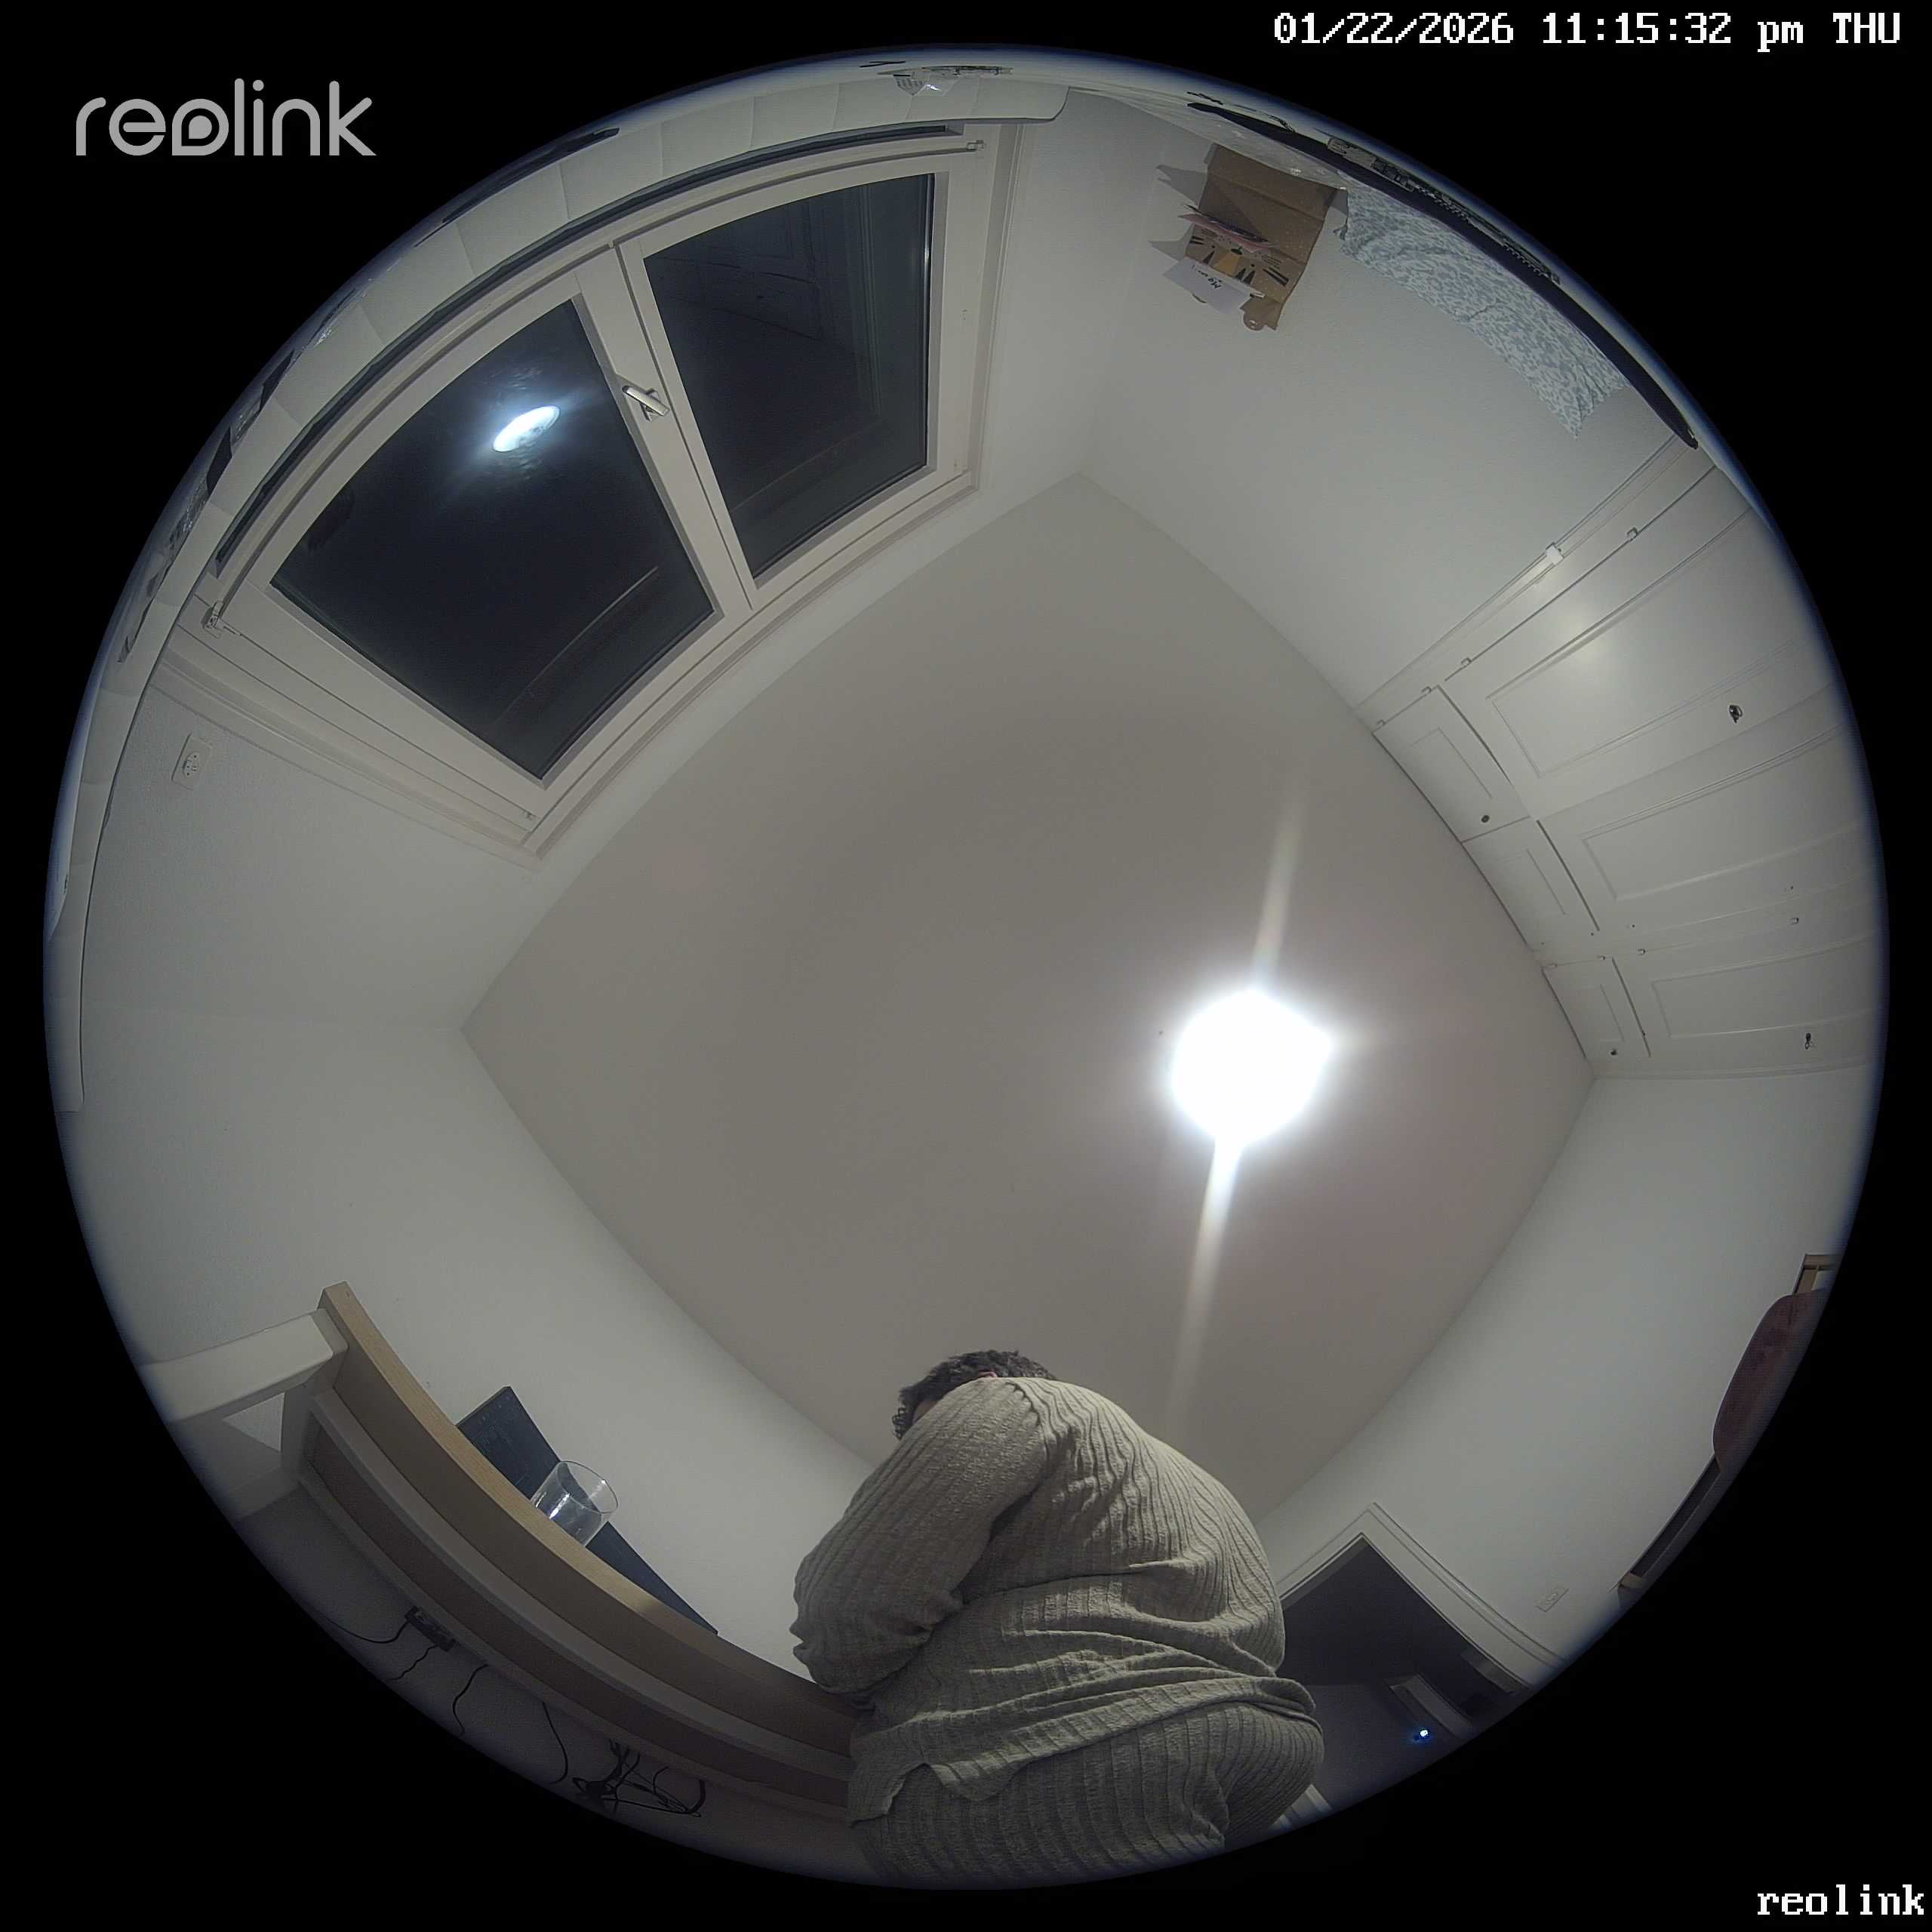


ROOM VIEWS

North-Down 45°:


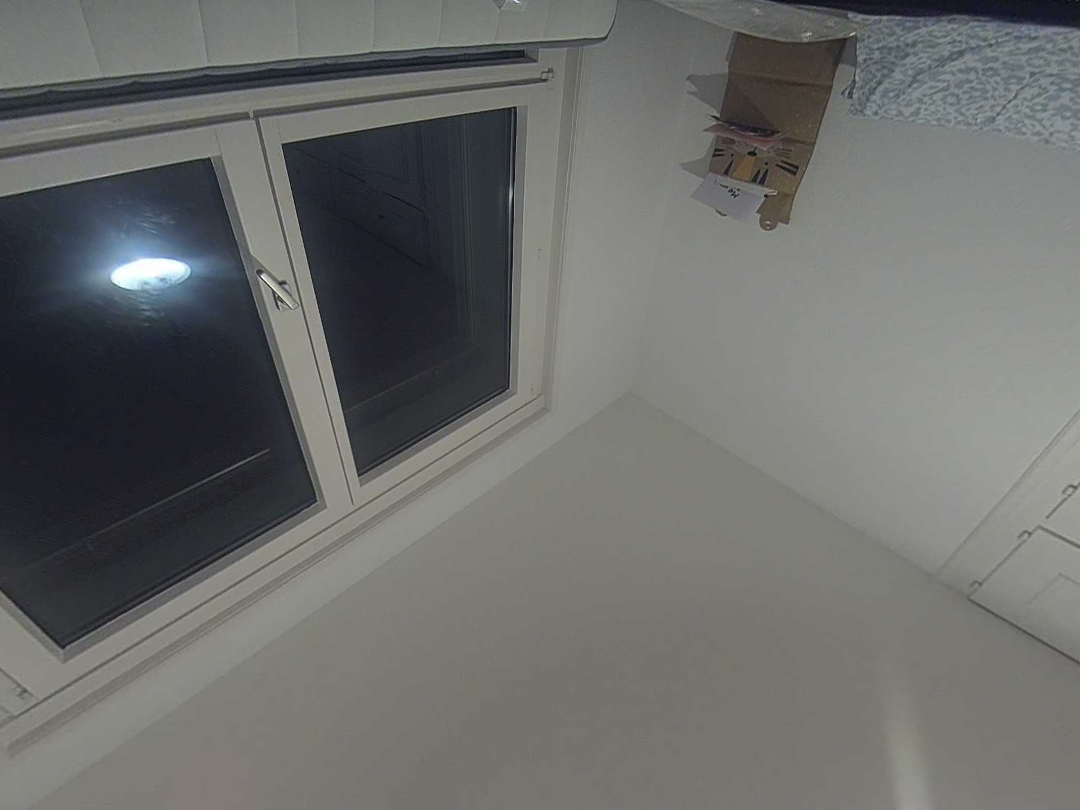


East-Down 45°:


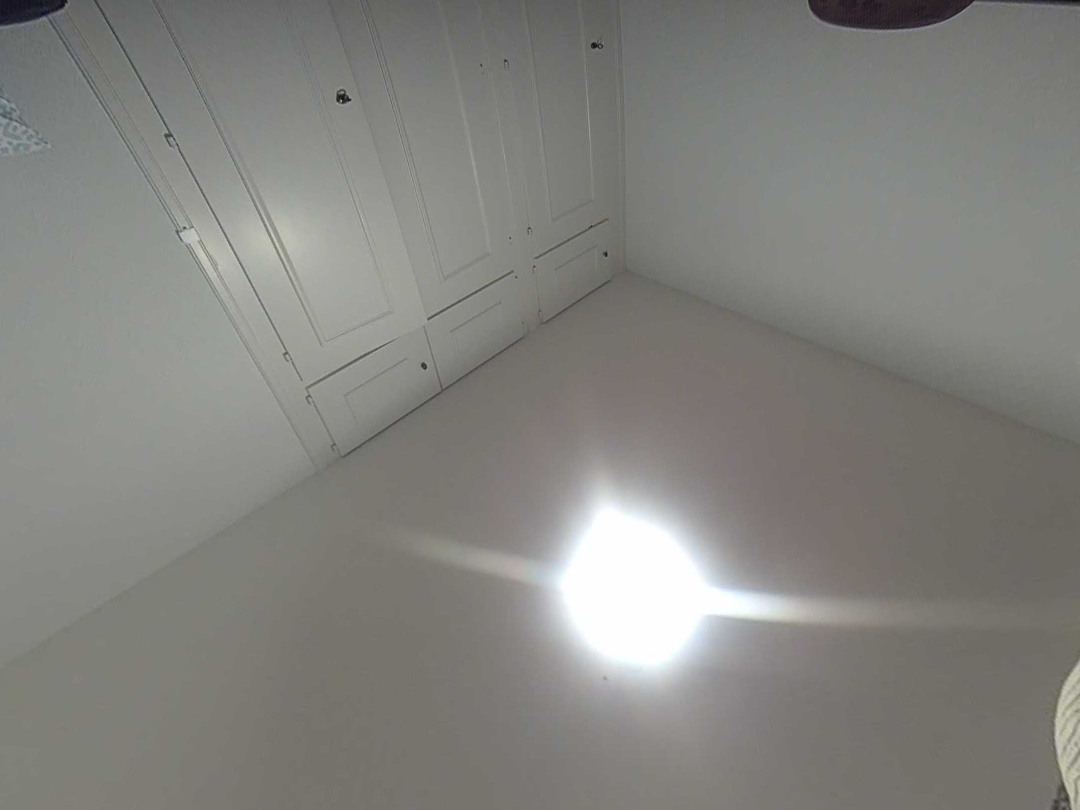


South-Down 45°:


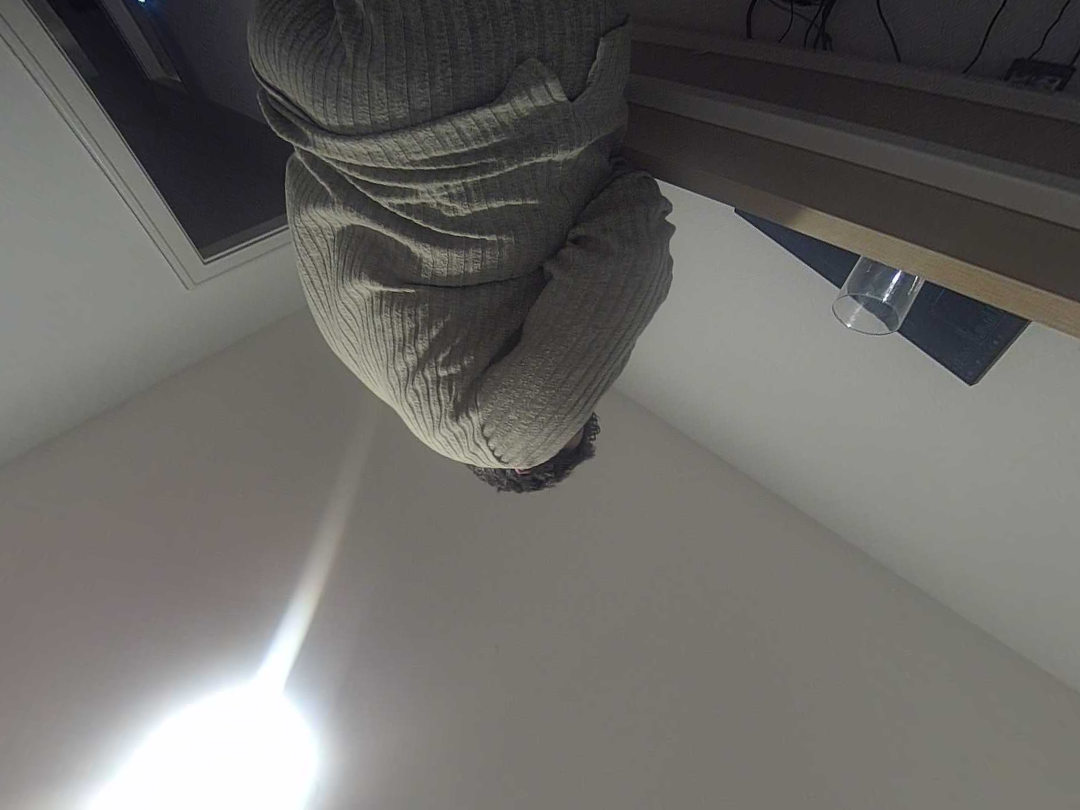


West-Down 45°:


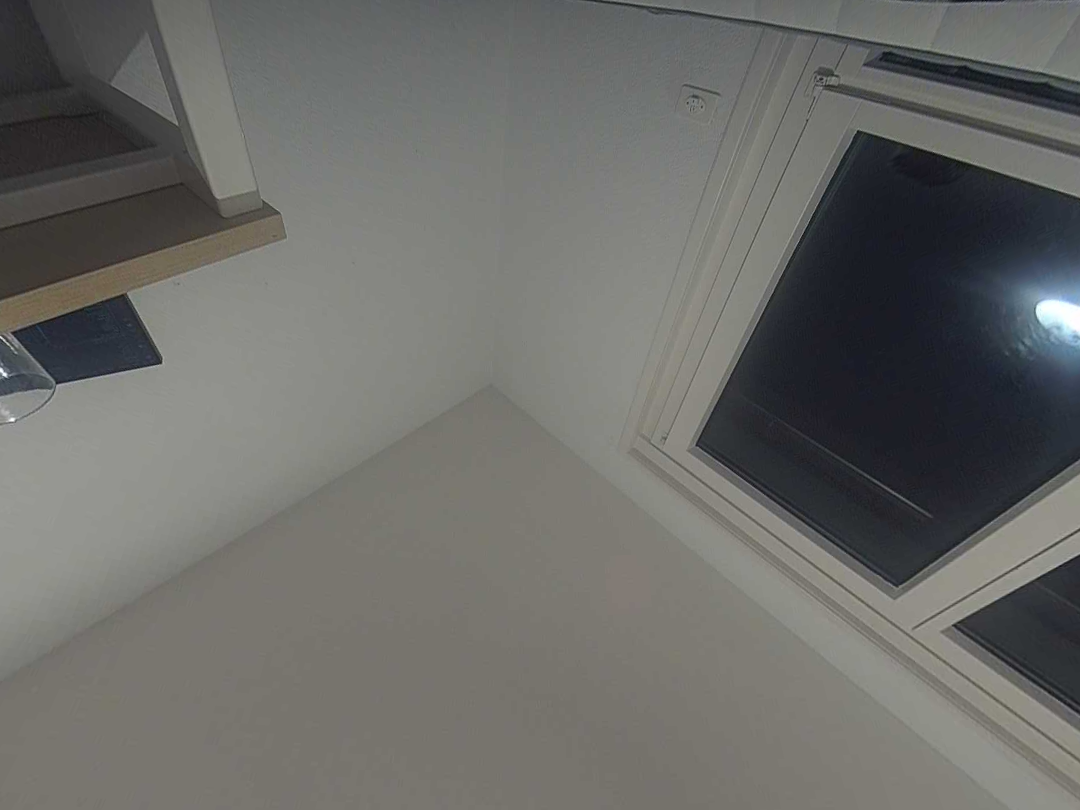


Directly Below (floor):


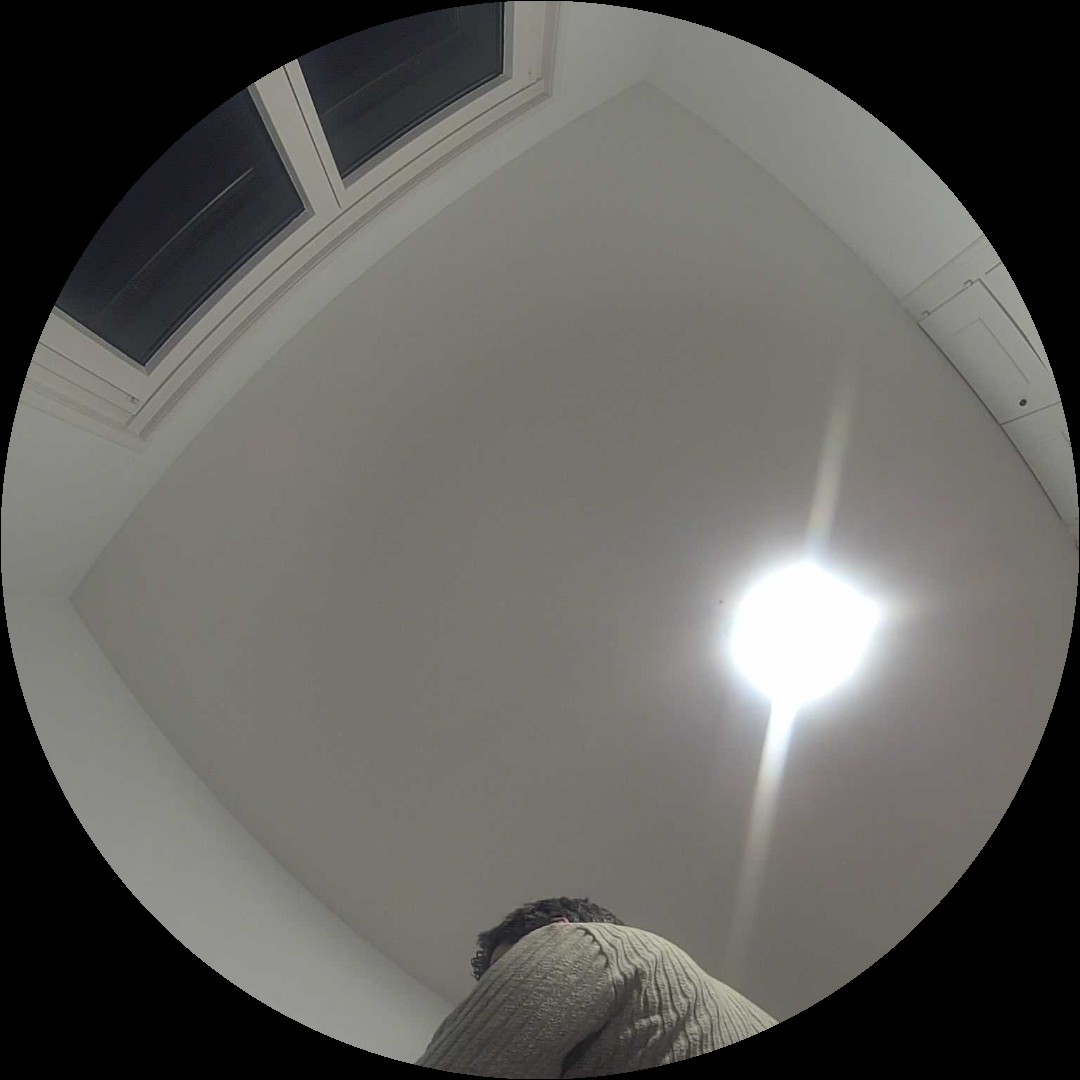

In [ ]:
# Test an image
def create_perspective_map(fisheye_shape, output_size, fov, theta, phi):
    """
    Create remap arrays for fast fisheye to perspective conversion.
    
    For ceiling-mounted fisheye cameras looking DOWN:
    - phi=0 means looking at the horizon (walls)
    - phi>0 means tilting DOWN toward the floor
    - The fisheye center = floor directly below camera
    - The fisheye edge = horizon/walls
    """
    h, w = fisheye_shape[:2]
    cx, cy = w / 2, h / 2
    radius = min(cx, cy)
    
    out_w, out_h = output_size
    
    # Convert angles to radians
    fov_rad = np.radians(fov)
    theta_rad = np.radians(theta)
    phi_rad = np.radians(phi)
    
    # Focal length
    f = out_w / (2 * np.tan(fov_rad / 2))
    
    # Create coordinate grids
    x = np.arange(out_w) - out_w / 2
    y = np.arange(out_h) - out_h / 2
    x_grid, y_grid = np.meshgrid(x, y)
    
    # Normalize coordinates
    x_norm = x_grid / f
    y_norm = -y_grid / f  # Flip Y to correct upside-down issue
    z_norm = np.ones_like(x_norm)
    
    # Stack into rays and normalize
    rays = np.stack([x_norm, y_norm, z_norm], axis=-1)
    rays = rays / np.linalg.norm(rays, axis=-1, keepdims=True)
    
    # Rotation matrices
    cos_t, sin_t = np.cos(theta_rad), np.sin(theta_rad)
    cos_p, sin_p = np.cos(phi_rad), np.sin(phi_rad)
    
    # Combined rotation: first tilt (X), then pan (Y)
    Ry = np.array([
        [cos_t, 0, sin_t],
        [0, 1, 0],
        [-sin_t, 0, cos_t]
    ])
    Rx = np.array([
        [1, 0, 0],
        [0, cos_p, -sin_p],
        [0, sin_p, cos_p]
    ])
    R = Ry @ Rx
    
    # Apply rotation to all rays
    rays_rotated = np.einsum('ij,hwj->hwi', R, rays)
    
    # Convert to spherical coordinates
    rx, ry, rz = rays_rotated[..., 0], rays_rotated[..., 1], rays_rotated[..., 2]
    
    # Angle from the vertical axis (nadir)
    # For a ceiling-mounted camera: 0 = straight down, pi/2 = horizon
    angle_from_nadir = np.arccos(np.clip(-ry, -1, 1))  # -ry because Y points up, nadir is -Y
    
    # Azimuth angle around the vertical axis
    azimuth = np.arctan2(rx, rz)
    
    # Map to fisheye using equidistant projection
    # angle_from_nadir = 0 -> center of fisheye (r=0)
    # angle_from_nadir = pi/2 -> edge of fisheye (r=radius)
    r_fish = (angle_from_nadir / (np.pi / 2)) * radius
    
    map_x = (cx + r_fish * np.sin(azimuth)).astype(np.float32)
    map_y = (cy - r_fish * np.cos(azimuth)).astype(np.float32)
    
    return map_x, map_y


def fisheye_to_perspective_fast(img, fov=90, theta=0, phi=0, output_size=(800, 600)):
    """
    Fast fisheye to perspective conversion using OpenCV remap.
    
    :param img: Input fisheye image (BGR)
    :param fov: Field of view in degrees (smaller = more zoom)
    :param theta: Pan angle 0-360° (rotation around vertical axis)
    :param phi: Tilt angle in degrees (0=horizon, positive=looking down toward floor)
    :param output_size: (width, height) of output
    """
    map_x, map_y = create_perspective_map(img.shape, output_size, fov, theta, phi)
    return cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)


def extract_center_view(img, radius_fraction=0.3, output_size=(600, 600)):
    """
    Extract and unwarp the center portion of a fisheye image (directly below the camera).
    Good for looking straight down at the floor.
    
    :param img: Input fisheye image
    :param radius_fraction: How much of the fisheye radius to capture (0.3 = inner 30%)
    :param output_size: Output image size
    """
    h, w = img.shape[:2]
    cx, cy = w / 2, h / 2
    radius = min(cx, cy)
    
    out_w, out_h = output_size
    
    # Create output coordinate grid
    x = np.linspace(-1, 1, out_w)
    y = np.linspace(-1, 1, out_h)
    x_grid, y_grid = np.meshgrid(x, y)
    
    # Map to fisheye coordinates (simple radial mapping for center region)
    r_out = np.sqrt(x_grid**2 + y_grid**2)
    theta_out = np.arctan2(y_grid, x_grid)
    
    # Scale radius to capture only the center portion
    r_fish = r_out * radius * radius_fraction
    
    # Convert back to cartesian
    map_x = (cx + r_fish * np.cos(theta_out)).astype(np.float32)
    map_y = (cy + r_fish * np.sin(theta_out)).astype(np.float32)
    
    # Mask out corners (make it circular)
    mask = r_out <= 1.0
    
    result = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    
    # Optional: mask corners to black
    result[~mask] = 0
    
    return result

def get_room_views(
        img,
        fov=90,
        output_size=(640, 480),
        view_limit_angle: int = 45,
        view_below_fraction: float = 0.6):
    """
    Generate perspective views covering the entire fisheye image.
    Returns a dict of direction -> image.
    
    For ceiling-mounted camera:
    - phi=0: looking at horizon/walls
    - phi=45: looking down at 45° angle
    - phi=80: looking almost straight down
    """
    directions = {
        # 'North (wall)': (0, 0),
        # 'East (wall)': (90, 0),
        # 'South (wall)': (180, 0),
        # 'West (wall)': (270, 0),
        'North-Down 45°': (0, view_limit_angle),
        'East-Down 45°': (90, view_limit_angle),
        'South-Down 45°': (180, view_limit_angle),
        'West-Down 45°': (270, view_limit_angle),
    }
    
    views = {}
    for name, (theta, phi) in directions.items():
        views[name] = fisheye_to_perspective_fast(img, fov=fov, theta=theta, phi=phi, output_size=output_size)
    
    # Add center view using special extraction method (for straight down)
    views['Directly Below (floor)'] = extract_center_view(img, radius_fraction=view_below_fraction, output_size=(output_size[0], output_size[0]))
    
    return views


# Get a snapshot to test dewarping
image = cam.get_snap()
if image:
    # Convert PIL to OpenCV format (BGR)
    img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    
    print("Original fisheye image:")
    display(image)
    
    # Generate all room views
    print("\n" + "="*50)
    print("ROOM VIEWS")
    print("="*50)
    
    views = get_room_views(img_cv, fov=90, output_size=(1080, 810))
    
    for name, view in views.items():
        print(f"\n{name}:")
        view_rgb = cv2.cvtColor(view, cv2.COLOR_BGR2RGB)
        display(PILImage.fromarray(view_rgb))
else:
    print("Could not get snapshot")

In [ ]:
# # Live mode

# import cv2

# # Create a RESIZABLE window
# WINDOW_NAME = "Reolink Camera (drag edges to resize, press 'q' to quit)"
# cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_NORMAL)  # WINDOW_NORMAL allows resizing
# cv2.resizeWindow(WINDOW_NAME, 800, 800)  # Set initial size

# # Open video stream
# stream = cam.open_video_stream()
# print("Stream started. Press 'q' in the window to quit.")

# for frame in stream:
#     cv2.imshow(WINDOW_NAME, frame)
    
#     # Check for 'q' key to quit
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cv2.destroyAllWindows()
# print("Stream stopped.")

error: OpenCV(4.13.0) /io/opencv/modules/highgui/src/window.cpp:1284: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvNamedWindow'


## 7. Snapshots for ML Processing

You can either save to disk or process directly in memory:

In [ ]:
# Get snapshot (returns PIL Image)
image = cam.get_snap()
image_np = np.array(image)
views = get_room_views(image_np, fov=90, output_size=(1080, 810))

image_np = views['Directly Below (floor)']
_, encoded = cv2.imencode('.jpg', cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))
image_bytes = encoded.tobytes()

image_base64 = base64.b64encode(image_bytes).decode('utf-8')

In [10]:
prompt = "Analyze this image"

response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}
                },
            ],
        }
    ],
)
print(response.choices[0].message.content)

This image appears to be taken with a fisheye lens or a camera with a wide-angle effect, resulting in a circular, distorted view. The photo shows the ceiling of a room with a bright ceiling light in the upper right corner. There's also a window in the upper left corner. In the lower part of the image, part of a person's shoulder with a ribbed, grayish sweater or garment is visible. The image has a compressed, warped perspective due to the lens effect.
